In [1]:
import sys
import numpy as np
import import_ipynb
import pandas as pd
from pathlib import Path
from scipy.sparse.linalg import spsolve
from scipy.constants import mu_0, epsilon_0

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))

# Verifique se os caminhos foram adicionados
print("Project root added to sys.path:", project_root)

# Importando notebooks diretamente
try:
    import problem_statement as ps
    from fem_pre_processing import read_mesh
    from fem_processing import boundary_conditions
    from fem_pos_processing import graph_results
    print("Modules imports were successful!")
except ModuleNotFoundError as e:
    print(f"Modules were not found: {e}")
except ImportError as e:
    print(f"Error in import: {e}")
    
#run ../setup_project.py

Project root added to sys.path: C:\Users\adilt\OneDrive\01 ACADEMIA\06 MODELOS\8.FEM\ppgee\projects
Todas as propriedades foram verificadas com sucesso para os elementos P1!
Todas as propriedades foram verificadas com sucesso para os elementos P2!
Todas as propriedades foram verificadas com sucesso para os elementos P3!
Todas as propriedades foram verificadas com sucesso para os elementos Q1!
Todas as propriedades foram verificadas com sucesso para os elementos Q2!
Modules imports were successful!
Modules imports were successful!
Modules imports were successful!


## Physics Constants

In [2]:
K0 = 2 * np.pi * 3E8 * np.sqrt(mu_0 * epsilon_0)
WAVELENGTH = 2 * np.pi / K0
print(f'Wavelength: {WAVELENGTH} m')
print(f'K0**2: {K0**2} 1/m')

Wavelength: 0.9993081933333551 m
K0**2: 39.53309720435509 1/m


# Project 3: 3-noded Linear Triangular Elements, $P_1$
# Pre-processor module
## Geometry and mesh Domain

In [3]:
FINITE_ELEMENT = ("Triangle", 1)

BOUNDARY = [{'tag': 101, 'type': 'Dirichlet', 'value': None, 'name': 'circular_scatterer'},
            {'tag': 102, 'type': 'PML', 'value': None, 'name': 'inner_truncated_domain'},
            {'tag': 103, 'type': 'PML', 'value': None, 'name': 'outer_truncated_domain'}]

MATERIAL = [{'tag': 201, 'name': 'PML',
             'relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
             {'tag': 202, 'name': 'free_space',
             'relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1}]

OMEGA_KEY = 'a'

# Criar geometria coaxial
ps.create_domain(FINITE_ELEMENT, BOUNDARY, MATERIAL, OMEGA_KEY, view_mesh=False)

# Create mesh from file geometry
mesh_data = read_mesh.get_data(FINITE_ELEMENT, BOUNDARY, MATERIAL, model='rectangular_pml')

Model rectangular_pml_domain_Triangle1 (2D)
Info     : 20 geometric entities
Info     : 5 Physical Groups
Info     : 4072 nodes in total
Info     : 7841 2-D elements in total


## Mesh Data Dictionaries

In [4]:
cell_data = mesh_data['cell']; cell_data[1]

{'Tag': 464,
 'conn': [820, 1717, 821],
 'material': {'tag': 201,
  'name': 'PML',
  'relative_magnetic_permeability': 1,
  'relative_electric_permittivity': 1}}

In [5]:
nodes_data = mesh_data['nodes']; nodes_data[1]

{'xg': (-0.9993081933333551, -0.9993081933333551),
 'bc': {'type': 'PML', 'value': None}}

## Figure 1: Coaxial meshed domain 

In [6]:
#graph_results.plot_mesh(FINITE_ELEMENT, mesh_data, model='circular_pec', Numbering=False)

<figure>
    <img src="pre_processing/pictures/circular_pec_meshed_domain_Triangle1.svg" alt="Fig.1" style="width:90%;" />
    <figcaption>Figure 1: Coaxial meshed domain.</figcaption>
</figure>

# Processor module
## `apply_physics()`

In [7]:
mesh_data = ps.apply_physics(FINITE_ELEMENT, mesh_data, OMEGA_KEY, n=1)

In [8]:
cell_data[1]

{'Tag': 464,
 'conn': [820, 1717, 821],
 'material': {'tag': 201,
  'name': 'PML',
  'relative_magnetic_permeability': 1,
  'relative_electric_permittivity': 1},
 'source': {'type': 'free_source', 'value': 0},
 'stiffness_a_value': array([[1.        -0.32370393j, 0.        +0.j        ],
        [0.        +0.j        , 0.90515412+0.29300194j]]),
 'mass_a_value': (1-0.3237039272958951j),
 'abc': {'type': None, 'conn_idx': None}}

In [9]:
nodes_data[1]

{'xg': (-0.9993081933333551, -0.9993081933333551),
 'bc': {'type': 'PML', 'value': None}}

## Imposition of Boundary Conditions

### $Dirichlet$ nodes

In [10]:
dirichlet_nodes = {key: value 
                   for key, value in nodes_data.items() if value['bc']['type'] == 'Dirichlet'}

### $PML$ Nodes

In [11]:
pml_nodes = {key: value 
             for key, value in nodes_data.items() if value['bc']['type'] == 'PML'}

In [12]:
free_nodes = {key: value 
              for key, value in nodes_data.items() if value['bc']['type'] != 'Dirichlet'}

In [13]:
Nn = len(nodes_data); Nd = len(dirichlet_nodes)
print(f"The entire domain has {Nn} nodes: {Nn - Nd} free nodes; {Nd} Dirichlet nodes.")

The entire domain has 4072 nodes: 4009 free nodes; 63 Dirichlet nodes.


## Figure 2: `plot_coordinates()`

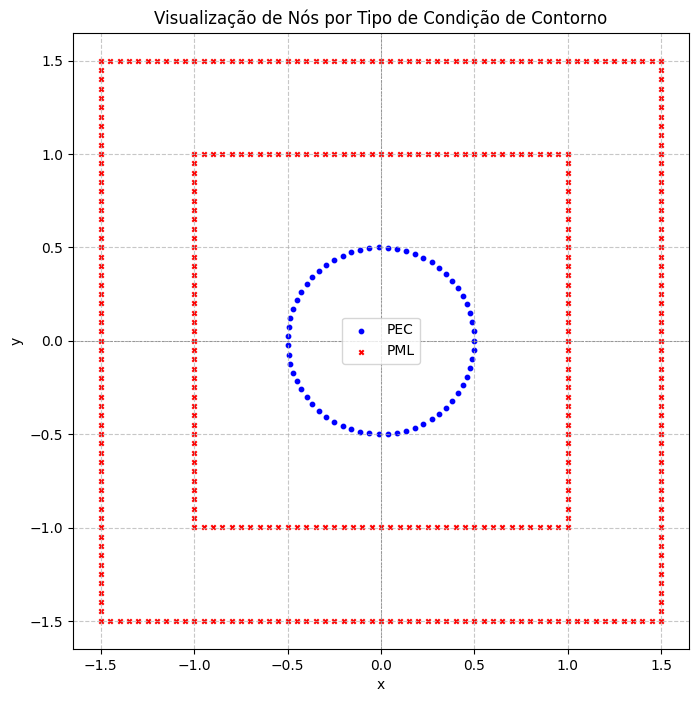

In [14]:
ps.plot_coordinates(mesh_data)

## Material Proprieties, $k_a$

In [15]:
ka = {key: value['stiffness_a_value'] for key, value in cell_data.items()}
# for key, node in ka.items():
#     print(f"Element {key}: \n{node}")

In [16]:
ma = {key: value['mass_a_value'] for key, value in cell_data.items()}

## Reduced Global matrix $A_{gr}$ with boundary conditions

In [17]:
Sgr, fgr, Mgr, Pgr, Qgr = boundary_conditions.reduced_global_matrices(FINITE_ELEMENT, mesh_data)
print("Reduced global matrix shape:", Sgr.shape)

Reduced global matrix shape: (4009, 4009)


## Global Potential Solution

In [18]:
Agr = Sgr - (K0 ** 2) * Mgr
ezr = spsolve(Agr.tocsr(), fgr.toarray())
ez_h = boundary_conditions.global_potentials_solution(mesh_data, ezr)

# `pml_attributes()`

In [19]:
OMEGA = 2 * np.pi * 3E8
K0 = OMEGA * np.sqrt(mu_0 * epsilon_0)
WAVELENGTH = 2 * np.pi / K0
OMEGA = {'a': {'h': WAVELENGTH/10, 'L': WAVELENGTH/2, 'ra': WAVELENGTH/2, 'x0': WAVELENGTH}}

# Lados do domínio retangular interno
x0 = OMEGA['a']['x0']   
y0 = x0
x, y = (1.1, 1.1)

# Cálculo de s_x
s_x = ps.calculate_sx(x, x0, n=1)
s_y = ps.calculate_sx(y, y0, n=1)
lambda_tensor, gamma = ps.pml_attributes(x, y, x0, y0, n=1)

print("Parâmetros do domínio PML:")
print("K0: ", K0)
print("x0: ", x0)
print(f"x: {x}, y: {y}")
print(f"s_x: {s_x}")
print(f"s_y: {s_y}")
print("1/s_x: ", 1/s_x)
print("1/s_y: ", 1/s_y)
print(f"Lambda:\n {lambda_tensor}")
print(f"Gamma: {gamma}")

Parâmetros do domínio PML:
K0:  6.287535065854908
x0:  0.9993081933333551
x: 1.1, y: 1.1
s_x: (1-0.147601219242938j)
s_y: (1-0.147601219242938j)
1/s_x:  (0.9786783951188681+0.14445412436626676j)
1/s_y:  (0.9786783951188681+0.14445412436626676j)
Lambda:
 [[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
Gamma: (0.9782138800779981-0.295202438485876j)


# $z$-component of electriz field scattered, $E_z^s$

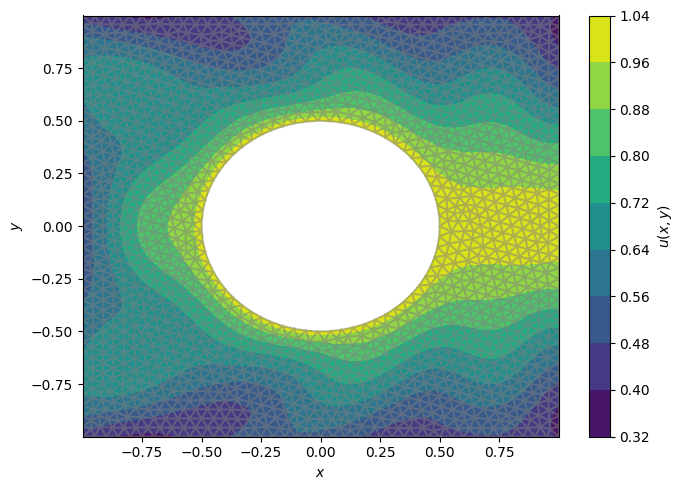

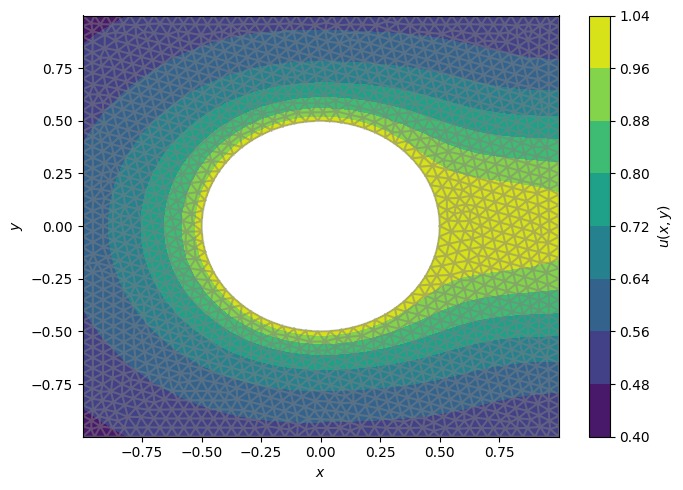

In [20]:
ez = ps.ez_at_omega(mesh_data, OMEGA_KEY)
ps.plot_ez_physical_domain(mesh_data, ez_h)
ps.plot_ez_physical_domain(mesh_data, ez)

Conversão do arquivo Jupyter Notebook para um script Python: ``python -m nbconvert --to script name.ipynb``

Belo Horizonte, Brazil. 2024.  
Adilton Junio Ladeira Pereira - adt@ufmg.br  
&copy; All rights reserved.